# Prepare environment

In [1]:
!pip install albumentations --user > /dev/null 2>&1

In [2]:
!pip install pretrainedmodels --user > /dev/null 2>&1

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv
from sklearn.neighbors import KNeighborsClassifier
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from torchvision import models

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Prepare data

In [8]:
train_df = pd.read_csv("./train.csv")
train_df.head()

,Image,Id
0,b4284d5ef.jpg,w_16b5050
1,4b82a9fc0.jpg,new_whale
2,16bf136fb.jpg,w_e73cce3
3,9805abc71.jpg,w_d6fde02
4,4e2803603.jpg,w_83a4279


In [9]:
train_df.Id.value_counts().head()

new_whale    7728
w_23a388d      60
w_9b5109b      55
w_0369a5c      54
w_9c506f6      52
Name: Id, dtype: int64

In [7]:
train_df = train_df[~(train_df.Id == "new_whale")]
train_df.Id.value_counts().head()

w_23a388d    60
w_9b5109b    55
w_0369a5c    54
w_9c506f6    52
w_700ebb4    46
Name: Id, dtype: int64

In [10]:
test_df = pd.read_csv("./new_whale_test.csv")

In [11]:
print(f"There are {len(os.listdir('./whaletrain'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
#print(f"There are {len(os.listdir('../data/test'))} images in test dataset with {test_df.Id.nunique()} unique classes.")
    

There are 20288 images in train dataset with 4571 unique classes.


In [12]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2182 classes with 1 samples in train data.
There are 1085 classes with 2 samples in train data.
There are 441 classes with 3 samples in train data.


In [13]:
len(train_df.Id)

20288

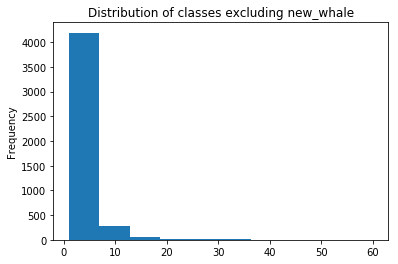

In [14]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Distribution of classes excluding new_whale');

In [15]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [16]:
y, le = prepare_labels(train_df['Id'])
y_ts, le_ts = prepare_labels(test_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

# Prepare Network

### Simple CNN

In [17]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [18]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [19]:
train_dataset = WhaleDataset(datafolder='./whaletrain/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whaletest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)

train_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
valid_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [69]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [46]:
model_conv = Net(4570)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Resnet 18

In [29]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [30]:
data_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [31]:
train_dataset = WhaleDataset(datafolder='./whaletrain/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whaletest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)
#test
train_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
valid_sampler = SubsetRandomSampler(list(range(len(train_df))))#len(os.listdir('./whaletrain')))))
batch_size = 10
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [20]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=4571):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [21]:
model_conv = ResNet(ResidualBlock)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [34]:
num_classes = 4571
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features #最后fc层的输入
model_conv.fc = nn.Linear(num_ftrs, num_classes) #NUM_CLASSES是自己数据的类别
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
model_conv.load_state_dict(torch.load('./model/Res18.pth'))

In [35]:
model_conv.cuda()
total = list(0. for i in range(test_df.Id.nunique()))
correct = list(0. for i in range(test_df.Id.nunique()))
# llloss = [0] * (n_epochs + 1)

accuracy = []
    
# train
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()
    output = model_conv(data)
    predicted = torch.argmax(output, 1)

    res = (predicted == torch.argmax(target, 1)).squeeze()

    for label_idx in range(len(target)):

        label_single = torch.argmax(target, 1)[label_idx]
        correct[label_single] += res[label_idx].item()
        total[label_single] += 1

acc = sum(correct)/sum(total)
print(f'acc : {acc}')

acc : 0.4764439187857284


# Train

### Every model use the same one

In [47]:
model_conv.cuda()
n_epochs = 10 #10
acc = [0] * (n_epochs + 1)
total = list(0. for i in range(train_df.Id.nunique()))
correct = list(0. for i in range(train_df.Id.nunique()))
llloss = [0] * (n_epochs + 1)

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    valid_loss = []
    exp_lr_scheduler.step()
    accuracy = []
    
    # train
    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        predicted = torch.argmax(output, 1)

        res = (predicted == torch.argmax(target, 1)).squeeze()
        
        for label_idx in range(len(target)):
            
            label_single = torch.argmax(target, 1)[label_idx]
            correct[label_single] += res[label_idx].item()
            total[label_single] += 1

        
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        
    llloss[epoch] = np.mean(train_loss)
    acc[epoch] = sum(correct)/sum(total)
    print(f'Epoch {epoch}, train loss: {llloss[epoch]}, acc : {acc[epoch]}')
    
acc_base_train = acc
loss_base_train = llloss

Mon Jun  3 17:55:23 2019 Epoch: 1


KeyboardInterrupt: 

In [53]:
torch.save(model_conv.state_dict(), './model/simplecnn_1epoch.pkl')
#model_object.load_state_dict(torch.load('params.pkl'))

In [ ]:
torch.save(model_conv.state_dict(), './model/resnet18.pkl')

In [28]:
model_conv.load_state_dict(torch.load('./model/simplecnn.pkl'))

In [37]:
result = []
model_conv.cuda()
for batch_i, (data, target) in enumerate(train_loader):
    #print(batch_i)
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model_conv(data)
    predicted = torch.argmax(output, 1)
    res = (predicted == torch.argmax(target, 1)).squeeze()
#     for i in range(len(predicted)):
#         result.append(predicted[i])


In [43]:
k = 0
for i in range(len(test_df.values)):
    if test_df.values[i][1] == 'new_whale':
        k+=1

In [46]:
k/len(test_df)

0.4764439187857284

## Feature Extraction

In [65]:
def myimshow(image, ax=plt):
    try:
        image = image.to('cpu').detach().numpy()
    except:
        image = image
    #image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

### Train_set feature extraction

In [20]:
class Net_ext(nn.Module):
    def __init__(self, num_classes):
        super(Net_ext, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 4 * 4 * 16)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)

        return x

In [21]:
model_conv_ext = Net_ext(4571)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model_conv_ext.parameters(), lr=0.01)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
model_conv_ext.load_state_dict(torch.load('./model/simplecnn.pkl'))

UnpicklingError: invalid load key, '\x0a'.

In [22]:
ext_1 = []
ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(train_loader):
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        ext_2.append((data[i].cpu().detach().numpy(),target[i]))
#     output = output.cpu().detach().numpy()
#     #print(batch_i)
#     data = data[0].cuda()
#     x = myexactor(data)



exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

exctrating data in batch297
exctrating data in batch298
exctrating data in batch299
exctrating data in batch300
exctrating data in batch301
exctrating data in batch302
exctrating data in batch303
exctrating data in batch304
exctrating data in batch305
exctrating data in batch306
exctrating data in batch307
exctrating data in batch308
exctrating data in batch309
exctrating data in batch310
exctrating data in batch311
exctrating data in batch312
exctrating data in batch313
exctrating data in batch314
exctrating data in batch315
exctrating data in batch316
exctrating data in batch317
exctrating data in batch318
exctrating data in batch319
exctrating data in batch320
exctrating data in batch321
exctrating data in batch322
exctrating data in batch323
exctrating data in batch324
exctrating data in batch325
exctrating data in batch326
exctrating data in batch327
exctrating data in batch328
exctrating data in batch329
exctrating data in batch330
exctrating data in batch331
exctrating data in b

exctrating data in batch590
exctrating data in batch591
exctrating data in batch592
exctrating data in batch593
exctrating data in batch594
exctrating data in batch595
exctrating data in batch596
exctrating data in batch597
exctrating data in batch598
exctrating data in batch599
exctrating data in batch600
exctrating data in batch601
exctrating data in batch602
exctrating data in batch603
exctrating data in batch604
exctrating data in batch605
exctrating data in batch606
exctrating data in batch607
exctrating data in batch608
exctrating data in batch609
exctrating data in batch610
exctrating data in batch611
exctrating data in batch612
exctrating data in batch613
exctrating data in batch614
exctrating data in batch615
exctrating data in batch616
exctrating data in batch617
exctrating data in batch618
exctrating data in batch619
exctrating data in batch620
exctrating data in batch621
exctrating data in batch622
exctrating data in batch623
exctrating data in batch624
exctrating data in b

In [23]:
len(train_loader)

634

In [199]:
model_conv_ext.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 9.1796e-02,  5.5529e-02,  7.5668e-02,  ..., -5.6558e-02,
                          5.5959e-02, -2.2185e-02],
                        [ 7.9609e-02,  9.3126e-02,  1.5645e-01,  ...,  9.4937e-02,
                          5.4867e-02,  6.9046e-02],
                        [ 1.0498e-01,  3.3667e-02,  9.1928e-02,  ...,  5.1464e-03,
                         -1.5053e-02, -2.1319e-02],
                        ...,
                        [ 1.1581e-01,  1.0193e-01,  1.5696e-01,  ...,  1.1076e-01,
                          1.5026e-01, -6.6370e-02],
                        [ 3.5093e-02, -1.6031e-03,  8.8651e-02,  ...,  1.4071e-01,
                         -1.4636e-03, -7.9728e-02],
                        [-6.4359e-02,  2.8535e-02,  1.1978e-02,  ..., -6.1638e-02,
                         -4.9941e-03, -1.3749e-01]],
              
                       [[-1.1197e-02,  2.4151e-02,  4.9759e-02,  ..., -3.3791e-02,
                         -6.4447

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


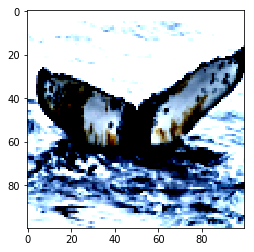

In [32]:
x = ext_2[2][0]#ext_1[2][0]
b = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.imshow(b) 

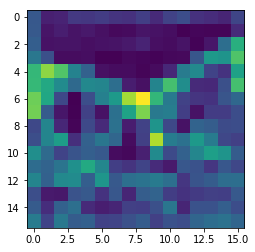

In [36]:
x = ext_1[2][0]#ext_1[2][0]
plt.imshow(x[6,:,:]) 

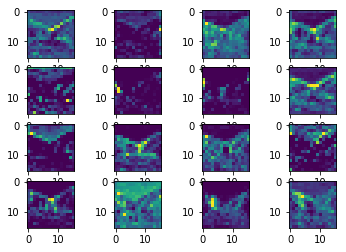

In [26]:
f_all = ext_1[2][0]
for i in range(16):
#     plt.subplots(4,4,figsize=(15,15))
    plt.subplot(4,4,i+1)
    f_img = f_all[2*i,:,:]
    plt.imshow(f_img)

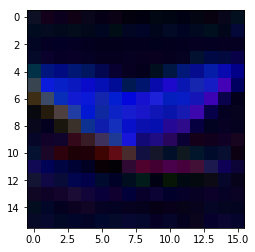

In [96]:
b = cv2.merge([x[1,:,:],x[4,:,:],x[9,:,:]])
plt.imshow(b) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


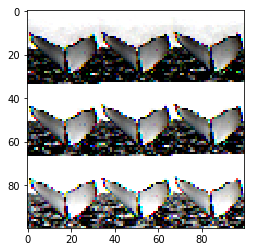

In [55]:
x = train_dataset.__getitem__(1000)[0]
x = x.reshape((100,100,3))
#x = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.imshow(x) 

In [66]:
ext_1[1][1]

tensor([1., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

### Test_set feature extraction

In [99]:
exact_list=["conv2","pool2"]
test_ext_1 = []
test_ext_2 = []
j = 0
model_conv_ext.cuda()
for (data, target, name) in test_loader:
    if j == 100:
        break
    print(f'exctrating data in batch{j}')
    j += 1
    data = data.cuda()
    output = model_conv_ext(data)
    for i in range(len(output[0])):
        test_ext_1.append((output[0][i].cpu().detach().numpy(),name))
        test_ext_2.append((output[1][i].cpu().detach().numpy(),name))    

ValueError: not enough values to unpack (expected 3, got 2)

In [25]:
test_ext_1 = []
test_ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(test_loader):
#     if batch_i == 20:
#         break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

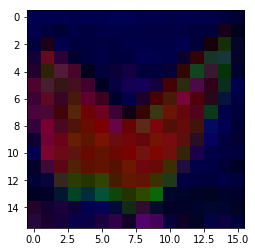

In [110]:
x1 = test_ext_1[0][0]
b = cv2.merge([x1[0,:,:],x1[1,:,:],x1[2,:,:]])
plt.imshow(b) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


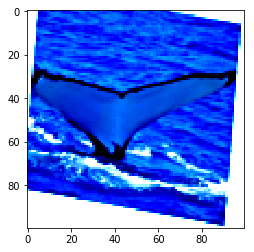

In [207]:
x2 = test_set[0][0]
b = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.imshow(b) 

In [ ]:
np.save("./data/simple_ext_1.npy",ext_1)
np.save("./data/simple_ext_2.npy",ext_2)
np.save("./data/simple_test_ext_1.npy",test_ext_1)
np.save("./data/simple_test_ext_2.npy",test_ext_2)

In [104]:
np.save("./data/untrain_cnn_ext_1_.npy", x)

In [39]:
np.save("./data/untrain_cnn_test_ext_2_nowhale.npy", x_ts)

In [25]:
len(ext_1)

20288

In [ ]:
x = np.zeros((len(ext_1), 16384))
y_n = np.zeros(len(ext_1))
for i in range(len(ext_1)):
    x[i, :]= ext_1[i][0].reshape(1, 16384)
    y_n[i] = np.argmax(ext_1[i][1].cpu().detach().numpy(), axis = 0)
x_ts = np.zeros((len(test_ext_1), 16384))
y_n_ts = np.zeros(len(test_ext_1))
for i in range(len(test_ext_1)):
    x[i, :] = test_ext_1[i][0].reshape(1, 16384)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(), axis = 0)

In [99]:
len(test_ext_1)

5073

In [27]:
x = np.zeros((len(ext_2), 30000))
for i in range(len(ext_2)):
    x[i, :]= ext_2[i][0].reshape(1, 30000)
x_ts = np.zeros((len(test_ext_2), 30000))
for i in range(len(test_ext_2)):
    x[i, :]= test_ext_2[i][0].reshape(1, 30000)
y_n = np.argmax(y, axis = 1)
y_n_ts = np.argmax(y_ts, axis = 1)

## Classification

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knn_ae = KNeighborsClassifier(n_neighbors=3)
knn_ae.fit(x, y_n)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [24]:
knn_conv = KNeighborsClassifier(n_neighbors=3)
knn_conv.fit(x, y_n)
joblib.dump(knn_conv, "./model/knn_conv.m")

['./model/knn_conv.m']

In [139]:
knn3.score(x_ts, y_n_ts)#old 3nn

0.4764439187857284

In [108]:
knn1.score(x_ts, y_n_ts)#1nn

0.00019712201852946975

In [31]:
knn3.score(x_ts, y_n_ts)#3nn

0.4764439187857284

In [30]:
knn_ae.score(x_ts, y_n_ts) #ae

0.3682239306130495

In [27]:
knn_ae.score(x_ts, y_n_ts) #ae_less

0.0

In [31]:
joblib.dump(knn_ae, "./model/knn_ae.m")


['./model/knn_ae.m']

In [32]:
knn2 = joblib.load("./model/knn_ae.m")
knn2.score(x_ts, y_n_ts)

0.3682239306130495

In [33]:
from sklearn.svm import LinearSVC
svm1 = LinearSVC()
svm1.fit(x, y_n)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [37]:
score_svm = svm1.score(x_ts, y_n_ts)
print(score_svm)

0.0005913660555884093


In [34]:
score_svm = svm1.score(x_ts, y_n_ts) #ae_less
print(score_svm)

0.012615809185886064


In [35]:
joblib.dump(svm1, "./model/svm_ae.m")

['./model/svm_ae.m']

In [65]:
svm2 = joblib.load("./model/svm_ae.m")
score_svm = svm2.score(x_ts, y_n_ts)
print(score_svm)

0.0


## Auto-encoder

In [46]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 100, 100)
    return x

# class autoencoder(nn.Module):
#     def __init__(self):
#         super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 32, 7, padding=1),  # b, 16, 10, 10
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv2d(32, 64, 3, padding=1),  # b, 8, 3, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 3),  # b, 16, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 3, 7, padding=2),  # b, 8, 15, 15
# #             nn.ReLU(True),
# #             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
# #             nn.Tanh()
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [40]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=1),  
            nn.ReLU(True))
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.ReLU(True))
        self.pool2 = nn.MaxPool2d(3, stride=1, return_indices=True)  
        self.fc1 = nn.Linear(135424, 1024)
        self.fc2 = nn.Linear(1024, 135424)
        self.unpool2 = nn.MaxUnpool2d(3, stride=1)
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),  
            nn.ReLU(True))
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 7, padding=1),  
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), 
#             nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder1(x)
        (x, ind1) = self.pool1(x)
        x = self.encoder2(x)
        (x, ind2) = self.pool2(x)
        
        x = x.view(-1, 135424)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 64, 46, 46)
        x = self.unpool2(x, ind2)
        x = self.decoder2(x)
        x = self.unpool1(x, ind1)
        x = self.decoder1(x)
        return x

In [41]:
num_epochs = 10
learning_rate = 1e-3
model_ae = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

for epoch in range(num_epochs):
    t = time.time()
    for batch_i, (data, target) in enumerate(train_loader):
#     for data in train_loader:
        img = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model_ae(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print()
    print('time usage {} epoch [{}/{}], loss:{:.4f}'
          .format(time.time()-t, epoch+1, num_epochs, loss.data.item()))
    if epoch == 0:
        save_image(data[0], './dc_img/oring_image.png')
    pic = to_img(output.cpu().data)
    save_image(pic[0], './dc_img/image_{}.png'.format(epoch))


time usage 220.29894399642944 epoch [1/10], loss:1.1561

time usage 196.41710543632507 epoch [2/10], loss:1.1084

time usage 197.90096783638 epoch [3/10], loss:1.4234

time usage 197.2909059524536 epoch [4/10], loss:1.1579

time usage 195.38659858703613 epoch [5/10], loss:1.1047

time usage 189.65691757202148 epoch [6/10], loss:1.0533

time usage 190.73621344566345 epoch [7/10], loss:1.2506

time usage 194.84642338752747 epoch [8/10], loss:1.0363

time usage 191.25704741477966 epoch [9/10], loss:1.2939

time usage 198.2492973804474 epoch [10/10], loss:1.2014


In [43]:
# torch.save(model_ae.state_dict(), './model/conv_autoencoder_imporved.pth')

In [23]:
class autoencoder_ext(nn.Module):
    def __init__(self):
        super(autoencoder_ext, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=1),  
            nn.ReLU(True))
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.ReLU(True))
        self.pool2 = nn.MaxPool2d(3, stride=1, return_indices=True)  
        self.fc1 = nn.Linear(135424, 1024)
        self.fc2 = nn.Linear(1024, 135424)
        self.unpool2 = nn.MaxUnpool2d(3, stride=1)
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),  
            nn.ReLU(True))
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 7, padding=1),  
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), 
#             nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder1(x)
        (x, ind1) = self.pool1(x)
        x = self.encoder2(x)
        (x, ind2) = self.pool2(x)
        
        x = x.view(-1, 135424)
#         print(x.shape)
        x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         x = x.view(-1, 64, 46, 46)
#         x = self.unpool2(x, ind2)
#         x = self.decoder2(x)
#         x = self.unpool1(x, ind1)
#         x = self.decoder1(x)
        return x

In [24]:
model_ae_ext = autoencoder_ext().cuda()
model_ae_ext.load_state_dict(torch.load('./model/conv_autoencoder_imporved.pth'))

In [4]:
x = pic[5,:,:,:].reshape(3,100,100).numpy()
b = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.imshow(b) 

NameError: name 'pic' is not defined

In [25]:
ext_1 = []
ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(train_loader):
#     if len(ext_1) >= 10000:
#         break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_ae_ext.cuda()
    output = model_ae_ext(data)
    for i in range(len(output)):
        ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

exctrating data in batch297
exctrating data in batch298
exctrating data in batch299
exctrating data in batch300
exctrating data in batch301
exctrating data in batch302
exctrating data in batch303
exctrating data in batch304
exctrating data in batch305
exctrating data in batch306
exctrating data in batch307
exctrating data in batch308
exctrating data in batch309
exctrating data in batch310
exctrating data in batch311
exctrating data in batch312
exctrating data in batch313
exctrating data in batch314
exctrating data in batch315
exctrating data in batch316
exctrating data in batch317
exctrating data in batch318
exctrating data in batch319
exctrating data in batch320
exctrating data in batch321
exctrating data in batch322
exctrating data in batch323
exctrating data in batch324
exctrating data in batch325
exctrating data in batch326
exctrating data in batch327
exctrating data in batch328
exctrating data in batch329
exctrating data in batch330
exctrating data in batch331
exctrating data in b

exctrating data in batch590
exctrating data in batch591
exctrating data in batch592
exctrating data in batch593
exctrating data in batch594
exctrating data in batch595
exctrating data in batch596
exctrating data in batch597
exctrating data in batch598
exctrating data in batch599
exctrating data in batch600
exctrating data in batch601
exctrating data in batch602
exctrating data in batch603
exctrating data in batch604
exctrating data in batch605
exctrating data in batch606
exctrating data in batch607
exctrating data in batch608
exctrating data in batch609
exctrating data in batch610
exctrating data in batch611
exctrating data in batch612
exctrating data in batch613
exctrating data in batch614
exctrating data in batch615
exctrating data in batch616
exctrating data in batch617
exctrating data in batch618
exctrating data in batch619
exctrating data in batch620
exctrating data in batch621
exctrating data in batch622
exctrating data in batch623
exctrating data in batch624
exctrating data in b

In [50]:
len(ext_1)

20288

In [6]:
f_all = ext_1[51][0]
for i in range(12):
#     plt.subplots(3,4,figsize=(15,15))
    plt.subplot(3,4,i+1)
    f_img = f_all[3*i,:,:]
    plt.imshow(f_img)

IndexError: list index out of range

In [7]:
x = ext_1[51][0]
# plt.imshow(x[6,:,:]) 
ext_1[51][0].shape

IndexError: list index out of range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


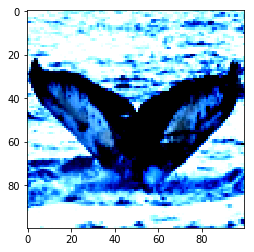

In [68]:
x = ext_2[51][0]#ext_1[2][0]
b = cv2.merge([x[0,:,:],x[1,:,:],x[2,:,:]])
plt.imshow(b) 

In [26]:
test_ext_1 = []
test_ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(test_loader):
#     if batch_i == 20:
#         break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_ae_ext.cuda()
    output = model_ae_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

In [28]:
x = np.zeros((len(ext_1), 1024))
y_n = np.zeros(len(ext_1))
for i in range(len(ext_1)):
    x[i, :]= ext_1[i][0].reshape(1, 1024)
    y_n[i] = np.argmax(ext_1[i][1].cpu().detach().numpy(),axis=0)
x_ts = np.zeros((len(test_ext_1), 1024))
y_n_ts = np.zeros(len(test_ext_1))
for i in range(len(test_ext_1)):
    x_ts[i, :]= test_ext_1[i][0].reshape(1, 1024)
    y_n_ts[i] = np.argmax(test_ext_1[i][1].cpu().detach().numpy(),axis=0)

In [103]:
y_n_ts.shape

(5073,)

## Resnet18 feature extraction

In [25]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [31]:
data_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [32]:
train_dataset = WhaleDataset(datafolder='./whaletrain/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whaletest/', datatype='train', df=test_df, transform=data_transforms_test,y = y_ts)
#test
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whaletrain')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whaletest')))))
batch_size = 10
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)


In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [34]:
class Res_ext(nn.Module):
    def __init__(self, ResidualBlock, num_classes=4571):
        super(Res_ext, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
        return out


In [35]:
model_conv_ext_res = Res_ext(ResidualBlock)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv_ext_res.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
ext_1 = []
ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(train_loader):
    if batch_i == 2000:
        break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext_res.cuda()
    output = model_conv_ext_res(data)
    for i in range(len(output)):
        ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        ext_2.append((data[i].cpu().detach().numpy(),target[i]))

exctrating data in batch0
exctrating data in batch1
exctrating data in batch2
exctrating data in batch3
exctrating data in batch4
exctrating data in batch5
exctrating data in batch6
exctrating data in batch7
exctrating data in batch8
exctrating data in batch9
exctrating data in batch10
exctrating data in batch11
exctrating data in batch12
exctrating data in batch13
exctrating data in batch14
exctrating data in batch15
exctrating data in batch16
exctrating data in batch17
exctrating data in batch18
exctrating data in batch19
exctrating data in batch20
exctrating data in batch21
exctrating data in batch22
exctrating data in batch23
exctrating data in batch24
exctrating data in batch25
exctrating data in batch26
exctrating data in batch27
exctrating data in batch28
exctrating data in batch29
exctrating data in batch30
exctrating data in batch31
exctrating data in batch32
exctrating data in batch33
exctrating data in batch34
exctrating data in batch35
exctrating data in batch36
exctrating 

exctrating data in batch297
exctrating data in batch298
exctrating data in batch299
exctrating data in batch300
exctrating data in batch301
exctrating data in batch302
exctrating data in batch303
exctrating data in batch304
exctrating data in batch305
exctrating data in batch306
exctrating data in batch307
exctrating data in batch308
exctrating data in batch309
exctrating data in batch310
exctrating data in batch311
exctrating data in batch312
exctrating data in batch313
exctrating data in batch314
exctrating data in batch315
exctrating data in batch316
exctrating data in batch317
exctrating data in batch318
exctrating data in batch319
exctrating data in batch320
exctrating data in batch321
exctrating data in batch322
exctrating data in batch323
exctrating data in batch324
exctrating data in batch325
exctrating data in batch326
exctrating data in batch327
exctrating data in batch328
exctrating data in batch329
exctrating data in batch330
exctrating data in batch331
exctrating data in b

exctrating data in batch590
exctrating data in batch591
exctrating data in batch592
exctrating data in batch593
exctrating data in batch594
exctrating data in batch595
exctrating data in batch596
exctrating data in batch597
exctrating data in batch598
exctrating data in batch599
exctrating data in batch600
exctrating data in batch601
exctrating data in batch602
exctrating data in batch603
exctrating data in batch604
exctrating data in batch605
exctrating data in batch606
exctrating data in batch607
exctrating data in batch608
exctrating data in batch609
exctrating data in batch610
exctrating data in batch611
exctrating data in batch612
exctrating data in batch613
exctrating data in batch614
exctrating data in batch615
exctrating data in batch616
exctrating data in batch617
exctrating data in batch618
exctrating data in batch619
exctrating data in batch620
exctrating data in batch621
exctrating data in batch622
exctrating data in batch623
exctrating data in batch624
exctrating data in b

exctrating data in batch883
exctrating data in batch884
exctrating data in batch885
exctrating data in batch886
exctrating data in batch887
exctrating data in batch888
exctrating data in batch889
exctrating data in batch890
exctrating data in batch891
exctrating data in batch892
exctrating data in batch893
exctrating data in batch894
exctrating data in batch895
exctrating data in batch896
exctrating data in batch897
exctrating data in batch898
exctrating data in batch899
exctrating data in batch900
exctrating data in batch901
exctrating data in batch902
exctrating data in batch903
exctrating data in batch904
exctrating data in batch905
exctrating data in batch906
exctrating data in batch907
exctrating data in batch908
exctrating data in batch909
exctrating data in batch910
exctrating data in batch911
exctrating data in batch912
exctrating data in batch913
exctrating data in batch914
exctrating data in batch915
exctrating data in batch916
exctrating data in batch917
exctrating data in b

exctrating data in batch1170
exctrating data in batch1171
exctrating data in batch1172
exctrating data in batch1173
exctrating data in batch1174
exctrating data in batch1175
exctrating data in batch1176
exctrating data in batch1177
exctrating data in batch1178
exctrating data in batch1179
exctrating data in batch1180
exctrating data in batch1181
exctrating data in batch1182
exctrating data in batch1183
exctrating data in batch1184
exctrating data in batch1185
exctrating data in batch1186
exctrating data in batch1187
exctrating data in batch1188
exctrating data in batch1189
exctrating data in batch1190
exctrating data in batch1191
exctrating data in batch1192
exctrating data in batch1193
exctrating data in batch1194
exctrating data in batch1195
exctrating data in batch1196
exctrating data in batch1197
exctrating data in batch1198
exctrating data in batch1199
exctrating data in batch1200
exctrating data in batch1201
exctrating data in batch1202
exctrating data in batch1203
exctrating dat

exctrating data in batch1453
exctrating data in batch1454
exctrating data in batch1455
exctrating data in batch1456
exctrating data in batch1457
exctrating data in batch1458
exctrating data in batch1459
exctrating data in batch1460
exctrating data in batch1461
exctrating data in batch1462
exctrating data in batch1463
exctrating data in batch1464
exctrating data in batch1465
exctrating data in batch1466
exctrating data in batch1467
exctrating data in batch1468
exctrating data in batch1469
exctrating data in batch1470
exctrating data in batch1471
exctrating data in batch1472
exctrating data in batch1473
exctrating data in batch1474
exctrating data in batch1475
exctrating data in batch1476
exctrating data in batch1477
exctrating data in batch1478
exctrating data in batch1479
exctrating data in batch1480
exctrating data in batch1481
exctrating data in batch1482
exctrating data in batch1483
exctrating data in batch1484
exctrating data in batch1485
exctrating data in batch1486
exctrating dat

exctrating data in batch1736
exctrating data in batch1737
exctrating data in batch1738
exctrating data in batch1739
exctrating data in batch1740
exctrating data in batch1741
exctrating data in batch1742
exctrating data in batch1743
exctrating data in batch1744
exctrating data in batch1745
exctrating data in batch1746
exctrating data in batch1747
exctrating data in batch1748
exctrating data in batch1749
exctrating data in batch1750
exctrating data in batch1751
exctrating data in batch1752
exctrating data in batch1753
exctrating data in batch1754
exctrating data in batch1755
exctrating data in batch1756
exctrating data in batch1757
exctrating data in batch1758
exctrating data in batch1759
exctrating data in batch1760
exctrating data in batch1761


In [ ]:
test_ext_1 = []
test_ext_2 = []
#for (data, target, name) in train_loader:
for batch_i, (data, target) in enumerate(test_loader):
#     if batch_i == 20:
#         break
    print(f'exctrating data in batch{batch_i}')
    data = data.cuda()
    model_conv_ext.cuda()
    output = model_conv_ext(data)
    for i in range(len(output)):
        test_ext_1.append((output[i].cpu().detach().numpy(),target[i]))
        test_ext_2.append((data[i].cpu().detach().numpy(),target[i]))

In [22]:
x = np.zeros((len(ext_1), 16384))
for i in range(len(ext_1)):
    x[i, :]= ext_1[i][0].reshape(1, 16384)
x_ts = np.zeros((len(test_ext_1), 16384))
for i in range(len(test_ext_1)):
    x[i, :]= test_ext_1[i][0].reshape(1, 16384)
y_n = np.argmax(y, axis = 1)
y_n_ts = np.argmax(y_ts, axis = 1)

### Plot

In [30]:
len(train_df.values[0:999])

999

## Transfer Learning

In [15]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx - 1][0])
            label = self.y[idx - 1]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx - 1])
            label = np.zeros((4571,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [38]:
data_transforms = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

train_dataset = WhaleDataset(datafolder='./whaletrain/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whaletest/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whaletrain')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whaletest')))))
batch_size = 10

num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=num_workers)


In [39]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4571)


In [40]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [65]:
from tqdm import tqdm_notebook, _tqdm_notebook
_tqdm_notebook.tqdm_notebook.pandas()